# Customer support Email automation

I used Langchain/Langgraph to build a customer support email automation system for an AI agency, it consists of multiple AI agents working together to achieve the following steps:

* Check for new emails in GMAIL inbox.

* Categorize email into 'customer_complaint', 'product_enquiry', 'customer_feedback', 'unrelated'.

* Synthetise a query/question to extract relevant information from RAG related to customer email.

* Write a draft email to repond to client.

* Email verifier: Check the quality and correct formatting of the email, and ensure its relevancy.


In [ ]:
!pip -q install langchain langchain_community langchain-groq langgraph faiss-cpu sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.5/973.5 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 51.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.5/308.5 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.8/122.8 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 675.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

In [8]:
import os

os.environ['GROQ_API_KEY'] = "gsk_xxxxxxxxxxxxxx"
os.environ['MY_EMAIL'] = "a.kerrour0909@gmail.com"

In [9]:
from langchain_groq import ChatGroq

llm = ChatGroq(model_name="llama3-70b-8192", temperature=0.8)

## Build RAG chain

In [10]:
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_groq import ChatGroq
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser

In [11]:
loader = TextLoader("../data/agency.txt")
docs = loader.load()

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=200, chunk_overlap=20)
text_chunks = text_splitter.split_documents(docs)

embeddings = HuggingFaceEmbeddings(model_name="BAAI/bge-small-en-v1.5")

# will automaticly convert given text chunks into vector using provided embeddings
# then we will store into FAISS DB
vectorstore = FAISS.from_documents(text_chunks, embeddings)

# this retriever will be used to pick chunks from vector store which have similarities with user query
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 4})

### Save DB locally

In [13]:
vectorstore.save_local("faiss_index")

### Load local store

In [14]:
new_vector_store = FAISS.load_local("faiss_index", embeddings, allow_dangerous_deserialization=True)

retriever = new_vector_store.as_retriever()

In [15]:
# standard QA prompt
template = """
<|begin_of_text|><|start_header_id|>system<|end_header_id|>
You are a helpful assistant for question-answering tasks.
Use the following pieces of retrieved context to answer the question.
If you don't know the answer, just say that I don't know.
<|eot_id|><|start_header_id|>user<|end_header_id|>
Question: {question}
Context: {context}
<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>
"""
prompt = ChatPromptTemplate.from_template(template)

# build retrieval chain using LCEL
# this will take the user query and generate the answer
rag_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [16]:
result = rag_chain.invoke("What AI models are supported?")
print(result)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


According to the context, the supported AI models include:

1. All OpenAI models
2. Llama3
3. Anthropic
4. Mistral
5. Gemini Pro


## Develop AI agents for Email automation

## 1- Categorize email

In [17]:
category_prompt_template = """<|begin_of_text|><|start_header_id|>system<|end_header_id|>
You are an expert email categorizer agent, you work at the customer  \
support department of SAAS specialized in the design of AI agents. \
You excel in understading users request and what they want. \
You role is to miticulsly analyse the provided email content and categorize it \
based on the following rules:
    product_enquiry - used when someone is asking for information about a product feature, benefit, service or about pricing \
    customer_complaint - used when someone is complaining about something \
    customer_feedback - used when someone is giving feedback about a product \
    unrelated - when it doesnt relate to any other category \

Your output must be JSON object with no premable or explaination.
The JSON output must contain a single key "category" which can only be from the types
('product_enquiry', 'customer_complaint', 'customer_feedback', 'unrelated')

<|eot_id|><|start_header_id|>user<|end_header_id|>
EMAIL CONTENT:\n\n {email} \n\n
<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>
"""
category_prompt = PromptTemplate(template=category_prompt_template, input_variables=["email"])
email_categorize_chain = category_prompt | llm | JsonOutputParser()

In [9]:
enquiry_email = """HI there, \n
I am emailing to find out info about how the created agents will be deployed

Thanks,
Paul
"""

result = email_categorize_chain.invoke({"email": enquiry_email})
print(result)

{'category': 'product_enquiry'}


In [10]:
complaint_email = """HI there, \n
I tried creating an agent with you platform but it didn't give th expected performance,
I am really dispointed and i am considering to request a refund.
"""

result = email_categorize_chain.invoke({"email": complaint_email})
print(result)

{'category': 'customer_complaint'}


## 2- Design RAG query

In [18]:
rag_query_prompt = """<|begin_of_text|><|start_header_id|>system<|end_header_id|>
You are an expert at analyzing the content of an email sent by our customers and extract \
what they are looking for. you role is to construct the most relevant query to be submit \
to our internal knowledge source in order to get the most appropriate answer. \
Return a JSON object with no premable or explaination, the JSON must include a single  \
key 'query' which must be a list of no more than 3 questions. \
<|eot_id|><|start_header_id|>user<|end_header_id|>
EMAIL CONTENT:\n\n {email} \n\n
<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>
"""
query_prompt = PromptTemplate(template=rag_query_prompt, input_variables=["email"])
design_rag_query_chain = query_prompt | llm | JsonOutputParser()

In [12]:
enquiry_email = """HI there, \n
I want to create an agent using the meta llama3 model, will that be possible

Thanks,
Paul
"""

result = design_rag_query_chain.invoke({"email": enquiry_email})
print(result)

{'query': ['Can I create an agent using the Meta LLaMA 3 model?', 'How do I create an agent with LLaMA 3?', 'Is LLaMA 3 model compatible with agent creation?']}


## 3- Create an email draft

In [19]:
draft_email_prompt = """<|begin_of_text|><|start_header_id|>system<|end_header_id|>
You are an expert email writer working for the customer support departement of an AI agents
development SAAS platform, you role is to create a draft email to answer our customers queries. \
Given an email category and a collection of research informations related the customers request, you must \
write a helpful email in a thoughtful and friendly way to answer the customer.
You must adhere to the following rules:
    If category is "product_enquiry" then you must use the given information to answer the customer in a friendly manner.
    If category is "customer_complaint" then try to assure we value them and that we will do our best to address their issues. \
    If category is "customer_feedback" then thank the customer for their cooperation and assure that we will take their feedback into account. \
    If category is "unrelated" then ask the customer to provide more information and that we will try our best to help him. \
Return a JSON object with no premable or explaination, the JSON must two keys: "subject", "email". \
Email must be from Agentia team. \
<|eot_id|><|start_header_id|>user<|end_header_id|>
EMAIL CATEGORY: {category} \n
EMAIL CONTENT:\n\n {email} \n\n
INFORMATIONS: \n {informations} \n
<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>
"""
draft_prompt = PromptTemplate(template=draft_email_prompt, input_variables=["category", "email", "informations"])
write_draft_email_chain = draft_prompt | llm | JsonOutputParser()

In [20]:
feedback_email = """HI there, \n
I used your platform to create an agent powered by OpenAI model and it was simple and smooth but the agent performance
was not good. This should be fixed in the future for a better experience.

Thanks,
Paul
"""

email_category = 'customer_feedback'
informations = None

response = write_draft_email_chain.invoke({"email": feedback_email, "category": email_category, "informations": informations})

In [15]:
import pprint

print("Email subject:", response["subject"])
pprint.pprint(response["email"])

Email subject: Thank you for your valuable feedback!
('Hi Paul,\n'
 '\n'
 'Thank you so much for taking the time to share your thoughts about your '
 "experience on our platform. We're thrilled to hear that creating an agent "
 'powered by OpenAI model was smooth and simple for you.\n'
 '\n'
 "We apologize that the agent's performance didn't quite meet your "
 "expectations. We'll make sure to take your feedback into account and work on "
 'improving the performance of our agents.\n'
 '\n'
 'Your input is invaluable to us, and we appreciate your help in shaping the '
 'future of our platform. If you have any other suggestions or ideas, please '
 "don't hesitate to share them.\n"
 '\n'
 'Thank you again for your feedback, and we hope to continue to improve and '
 'exceed your expectations in the future.\n'
 '\n'
 'Best regards,\n'
 'The Agentia Team')


## 4- Verify generated email

In [21]:
verify_email_prompt = """<|begin_of_text|><|start_header_id|>system<|end_header_id|>
As an email grading specialist, you excel in assessing the quality of email content and \
determining its readiness for sending. Your task involves analyzing an email generated \
by a writer agent to ensure it contains the appropriate response to the initial email \
sent by the customer. This response should align with the category of the initial email \
and accurately reflect the provided information.
You must return a JSON object with no premable or explaination, the JSON must include a single  \
key 'review' which can be either "send" or "rewrite". \
<|eot_id|><|start_header_id|>user<|end_header_id|>
INITIAL EMAIL CATEGORY: {category} \n
INITIAL EMAIL:\n\n {initial_email} \n\n
GENERATED EMAIL:\n\n {generated_email} \n\n
INFORMATIONS: \n {informations} \n
<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>
"""
verify_prompt = PromptTemplate(template=verify_email_prompt, input_variables=["category", "initial_email", "generated_email", "informations"])
verify_email_chain = verify_prompt | llm | JsonOutputParser()

In [17]:
feedback_email = """HI there, \n
I used your platform to create an agent powered by OpenAI model and it was simple and smooth but the agent performance
was not good. This should be fixed in the future for a better experience.

Thanks,
Paul
"""

email_category = 'customer_feedback'
informations = None

result = verify_email_chain.invoke({
    "initial_email": feedback_email,
    "category": email_category,
    "generated_email": response["email"],
    "informations": informations
    })
print(result)

{'review': 'send'}


In [18]:
feedback_email = """HI there, \n
I used your platform to create an agent powered by OpenAI model and it was simple and smooth but the agent performance
was not good. This should be fixed in the future for a better experience.

Thanks,
Paul
"""

email_category = 'customer_feedback'
informations = None

response = """
Sorry we can't help you right now.
"""

result = verify_email_chain.invoke({
    "initial_email": feedback_email,
    "category": email_category,
    "generated_email": response,
    "informations": informations
    })
print(result)

{'review': 'rewrite'}


## Create Email automation Graph

In [22]:
from typing_extensions import TypedDict
from typing import List
from pprint import pprint

In [23]:
### Our graph state
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        emails: List of email dictionaries containing details of new emails.
        viewed_emails_ids: List of email IDs that have been viewed.
        ready_emails: List of emails that are ready to be sent.
        email_sender: Email address of the sender of the current email.
        email_category: Category of the current email (e.g., product enquiry, customer feedback).
        email_subject: Subject of the generated email draft.
        generated_email: Content of the email generated by the write agent.
        rag_questions: List of questions designed for Retrieval-Augmented Generation (RAG).
        retrieved_infos: Information retrieved from RAG to answer enquiry.
        review: Review result of the generated email (send or rewrite).
        trials: Number of draft trials attempted before stopping.
    """
    emails: List[dict]
    viewed_emails_ids: List[str]
    ready_emails: List[dict]
    email_sender: str
    email_category: str
    email_subject: str
    generated_email: str
    rag_questions: List[str]
    retrieved_infos: str
    review: str
    trials: int


In [34]:
import os, re
from langchain_community.agent_toolkits import GmailToolkit
from langchain_community.tools.gmail.create_draft import GmailCreateDraft
from langchain_community.tools.gmail.search import GmailSearch

class Nodes:
    """
    The graph consist on the following nodes:
      * Load new emails
      * Categorize email
      * Design RAG queries
      * Retrieve from RAG
      * Write draft email
      * Verify generated email
    """

    def __init__(self):
      self.gmail = GmailToolkit()

    def load_new_emails(self, state):
      print("Loading new emails...\n")
      search = GmailSearch(api_resource=self.gmail.api_resource)
      emails = search('newer_than:1d')
      viewed_emails = state['viewed_emails_ids'] if state['viewed_emails_ids'] else []
      thread = []
      new_emails = []
      for email in emails:
        if (email['id'] not in viewed_emails) and (email['threadId'] not in thread) and (os.environ['MY_EMAIL'] not in email['sender']):
          sender = re.search(r'<([^>]+)>', email["sender"]).group(1)
          thread.append(email['threadId'])
          new_emails.append(
            {
              "id": email['id'],
              "threadId": email['threadId'],
              "snippet": email['snippet'],
              "sender": sender
            }
          )
      viewed_emails.extend([email['id'] for email in emails])
      return {
        **state,
        "emails": new_emails,
        "viewed_emails_ids": viewed_emails
      }

    def check_new_emails(self, state):
      print(state['emails'])
      if len(state['emails']) == 0:
        print("No new emails")
        return "empty"
      else:
        print("New emails to process")
        return "process"

    # def wait_next_run(self, state):
    #   print("Processed all emails, waiting for next run!!!")
    #   time.sleep(3600)
    #   return state

    def categorize_email(self, state):
      print("Checking email category...\n")
      emails = state["emails"]
      current_email = emails[-1]
      category_result = email_categorize_chain.invoke({"email": current_email})
      print("Email category:", category_result["category"])
      return {
        **state, 
        "email_category": category_result["category"],
        "email_sender": current_email["sender"]
        }

    def route_email_based_on_category(self, state):
      print("Routing email based on category...\n")
      category = state["email_category"]
      if category == "product_enquiry":
        return "product related"
      else:
        return "not product related"

    def construct_rag_questions(self, state):
      print("Designing RAG query...\n")
      emails = state["emails"]
      current_email = emails[-1]
      query_result = design_rag_query_chain.invoke({"email": current_email})
      return {**state, "rag_questions": query_result["query"]}

    def retrieve_from_rag(self, state):
      print("Retrieving informations from internal knowledge...\n")
      queries = state["rag_questions"]
      final_answer = ""
      for query in queries:
        rag_result = rag_chain.invoke(query)
        final_answer += query + "\n" + rag_result + "\n\n"
      return {**state, "retrieved_infos": final_answer}

    def write_draft_email(self, state):
      print("Writing draft email...\n")
      emails = state["emails"]
      current_email = emails[-1]
      draft_result = write_draft_email_chain.invoke({
          "email": current_email,
          "category": state["email_category"],
          "informations": state["retrieved_infos"]
          })
      email = draft_result["email"]
      subject = draft_result["subject"]
      if state['trials'] is None:
        state['trials'] = 0
      trials = int(state['trials'])
      trials += 1
      return {
        **state, 
        "email_subject": subject, 
        "generated_email": email, 
        "trials": trials
        }

    def verify_generated_email(self, state):
      print("Verifying generated email...\n")
      emails = state["emails"]
      current_email = emails[-1]
      verify_result = verify_email_chain.invoke({
          "initial_email": current_email,
          "category": state["email_category"],
          "generated_email": state["generated_email"],
          "informations": state["retrieved_infos"]
          })
      review = verify_result["review"]
      return {**state, "review": review}

    def must_rewrite(self, state):
      review = state["review"]
      if review == "send":
          print("Email is good, ready to be sent!!!")
          # remove processed email
          state["emails"].pop()
          return "send"
      elif state["trials"] >= 3:
          print("Email is not good, we reached max trials must stop!!!")
          # remove processed email
          state["emails"].pop()
          return "stop"
      else:
          print("Email is not good, must rewrite it...")
          return "rewrite"

    def send_email(self, state):
      print("Sending email...\n")
      # send email
      draft = GmailCreateDraft(api_resource=self.gmail.api_resource)
      result = draft({
          'to': [state["email_sender"]],
          'subject': state["email_subject"],
          'message': state["generated_email"]
      })

In [35]:
from langgraph.graph import END, StateGraph

# initiate graph state & nodes
workflow = StateGraph(GraphState)
nodes = Nodes()

# define all graph nodes
workflow.add_node("load_new_emails", nodes.load_new_emails)
workflow.add_node("categorize_email", nodes.categorize_email)
workflow.add_node("construct_rag_questions", nodes.construct_rag_questions)
workflow.add_node("retrieve_from_rag", nodes.retrieve_from_rag)
workflow.add_node("write_draft_email", nodes.write_draft_email)
workflow.add_node("verify_generated_email", nodes.verify_generated_email)
workflow.add_node("send_email", nodes.send_email)

# load new email
workflow.set_entry_point("load_new_emails")

# chech if there are email to process
workflow.add_conditional_edges(
    "load_new_emails",
    nodes.check_new_emails,
    {
        "process": "categorize_email",
        "empty": END
    }
)

# recheck for new emails after awaiting
# workflow.add_edge("wait_next_run", "load_new_emails")

# route email based on category
workflow.add_conditional_edges(
    "categorize_email",
    nodes.route_email_based_on_category,
    {
        "product related": "construct_rag_questions",
        "not product related": "write_draft_email",
    }
)

# pass constructed query to RAG chain to get informations
workflow.add_edge("construct_rag_questions", "retrieve_from_rag")
# give information to writer agent to create draft email
workflow.add_edge("retrieve_from_rag", "write_draft_email")
# verify the create draft email
workflow.add_edge("write_draft_email", "verify_generated_email")
# check if email is sendable or not, if not rewrite the email
workflow.add_conditional_edges(
    "verify_generated_email",
    nodes.must_rewrite,
    {
        "send": "send_email",
        "rewrite": "write_draft_email",
        "stop": "categorize_email"
    }
)

# check if there are still emails to be processed
workflow.add_conditional_edges(
    "send_email",
    nodes.check_new_emails,
    {
        "process": "categorize_email",
        "empty": END
    }
)

# Compile
app = workflow.compile()

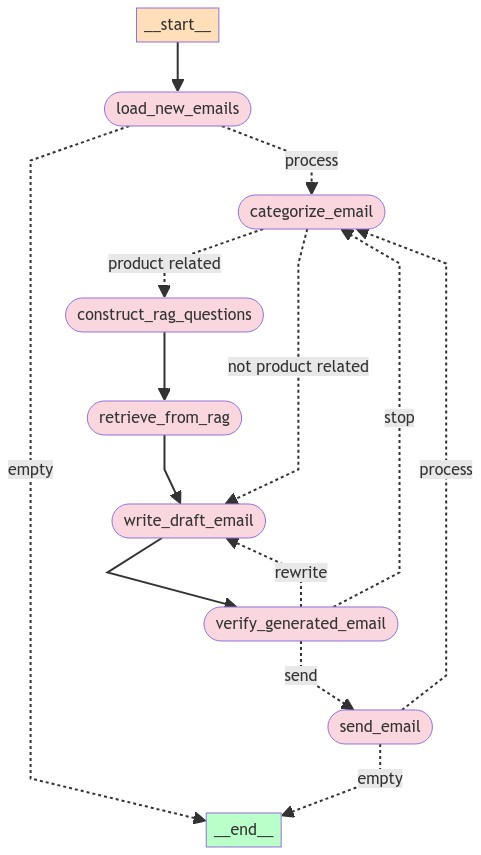

In [36]:
from langchain_core.runnables.graph import CurveStyle, NodeColors, MermaidDrawMethod
from IPython.display import display, HTML, Image

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [37]:
# EMAIL = """HI there, \n
# I am emailing to find out the current price of Bitcoin. \n

# Can you please help me/

# Thanks,
# John
# """

# EMAIL = """HI there, \n
# I am emailing to find out what are your current pricing plans. \n

# Thanks,
# Paul
# """


EMAIL = """HI there, \n

I am very pleased with your plaform, its very intuitive and easy to use.

Thanks,
Lisa
"""

In [38]:
# run the agent
for output in app.stream({}):
  for key, value in output.items():
      pprint(f"Finished running: {key}:")

Loading new emails...

[{'id': '18ffdd91ad277f12', 'threadId': '18ffdd91ad277f12', 'snippet': 'HI there, I am very pleased with your platform, it&#39;s very intuitive and easy to use. Thanks, Lisa', 'sender': 'aymenmir1001@gmail.com'}, {'id': '18ffdd8ca477003d', 'threadId': '18ffdd8ca477003d', 'snippet': 'HI there, I tried creating an agent with your platform but it didn&#39;t give the expected performance.I am really disappointed and I am considering requesting a refund.', 'sender': 'aymenmir1001@gmail.com'}]
New emails to process
'Finished running: load_new_emails:'
Checking email category...

Email category: customer_complaint
Routing email based on category...

'Finished running: categorize_email:'
Writing draft email...

'Finished running: write_draft_email:'
Verifying generated email...

Email is good, ready to be sent!!!
'Finished running: verify_generated_email:'
Sending email...

[{'id': '18ffdd91ad277f12', 'threadId': '18ffdd91ad277f12', 'snippet': 'HI there, I am very please